# AI4I 2020 - Model Experimentation Notebook

Dieses Notebook fokussiert sich auf schnelle Experimente mit verschiedenen ML-Modellen für Predictive Maintenance.

## Ziele:
- Datensatz laden und verstehen
- Grundlegende Datenverarbeitung
- Feature Engineering
- Verschiedene Modelle trainieren und vergleichen
- Erste Ergebnisse und Insights

## 1. Setup & Imports

In [19]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Optional: XGBoost (falls installiert)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("XGBoost ist verfügbar")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost nicht verfügbar - kann später installiert werden")

# Plotting Setup
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Setup abgeschlossen!")

XGBoost ist verfügbar
Setup abgeschlossen!


## 2. Daten laden und erste Exploration

In [20]:
# Datensatz laden
data_path = '../data/raw/ai4i2020.csv'
df = pd.read_csv(data_path)

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (10000, 14)

Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

First few rows:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [21]:
# Grundlegende Datenstatistiken
print("=== Datentypen und Info ===")
print(df.info())

print("\n=== Fehlende Werte ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Keine fehlenden Werte")

print("\n=== Numerische Statistiken ===")
df.describe()

=== Datentypen und Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


=== HAUPTTARGET: Machine failure ===
Verteilung:
Machine failure
0    9661
1     339
Name: count, dtype: int64
Prozentuale Verteilung:
Machine failure
0    96.61
1     3.39
Name: proportion, dtype: float64

=== SPEZIFISCHE AUSFALLTYPEN ===
TWF: 46 Ausfälle (0.46%)
HDF: 115 Ausfälle (1.15%)
PWF: 95 Ausfälle (0.95%)
OSF: 98 Ausfälle (0.98%)
RNF: 19 Ausfälle (0.19%)


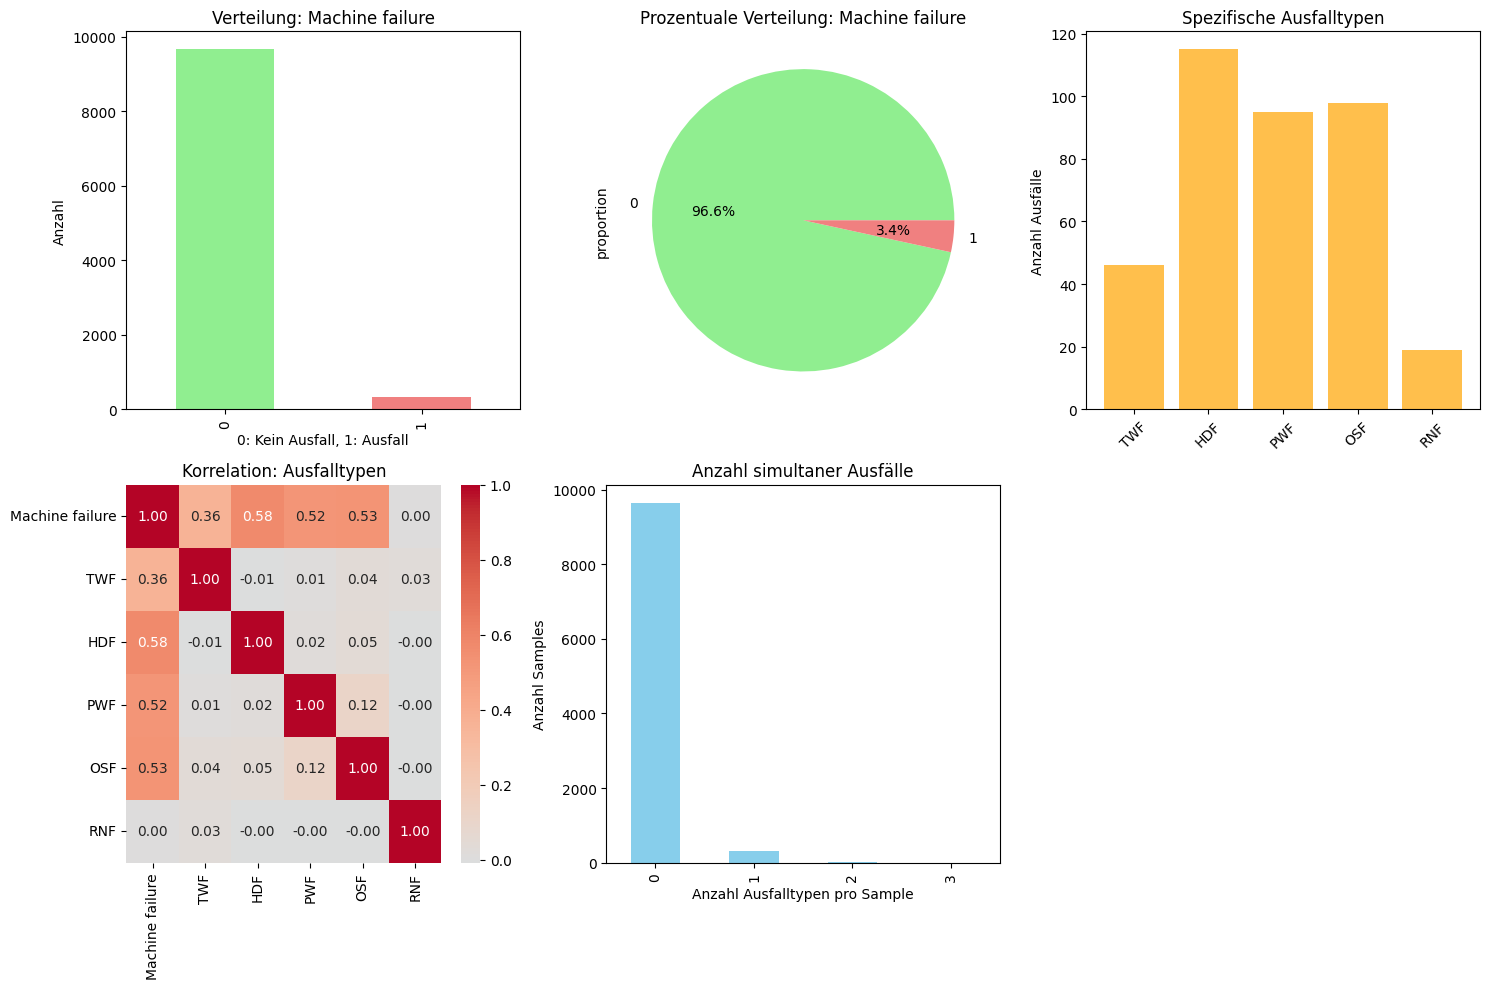


=== BEZIEHUNG ZWISCHEN GESAMTAUSFALL UND SPEZIFISCHEN AUSFÄLLEN ===
Machine failure = OR(spezifische Ausfälle): False
Anzahl Abweichungen: 27

✅ Target-Analyse abgeschlossen. Haupttarget: Machine failure


In [22]:
# Target-Variablen analysieren
# Hauptziel: Machine failure (Gesamtausfall)
target_col = 'Machine failure'

print(f"=== HAUPTTARGET: {target_col} ===")
print(f"Verteilung:")
target_counts = df[target_col].value_counts()
print(target_counts)
print(f"Prozentuale Verteilung:")
print(df[target_col].value_counts(normalize=True) * 100)

# Spezifische Ausfalltypen analysieren
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
print(f"\n=== SPEZIFISCHE AUSFALLTYPEN ===")

failure_summary = {}
for failure_type in failure_types:
    if failure_type in df.columns:
        counts = df[failure_type].value_counts()
        failure_summary[failure_type] = counts.get(1, 0)  # Anzahl der Ausfälle
        print(f"{failure_type}: {counts.get(1, 0)} Ausfälle ({counts.get(1, 0)/len(df)*100:.2f}%)")

# Visualisierung der Target-Verteilungen
plt.figure(figsize=(15, 10))

# Subplot 1: Haupttarget (Machine failure)
plt.subplot(2, 3, 1)
df[target_col].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title(f'Verteilung: {target_col}')
plt.ylabel('Anzahl')
plt.xlabel('0: Kein Ausfall, 1: Ausfall')

# Subplot 2: Prozentuale Verteilung Haupttarget
plt.subplot(2, 3, 2)
df[target_col].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', 
                                                colors=['lightgreen', 'lightcoral'])
plt.title(f'Prozentuale Verteilung: {target_col}')

# Subplot 3: Spezifische Ausfalltypen (Balkendiagramm)
plt.subplot(2, 3, 3)
failure_counts = [failure_summary.get(ft, 0) for ft in failure_types]
plt.bar(failure_types, failure_counts, color='orange', alpha=0.7)
plt.title('Spezifische Ausfalltypen')
plt.ylabel('Anzahl Ausfälle')
plt.xticks(rotation=45)

# Subplot 4: Korrelation zwischen Machine failure und spezifischen Ausfällen
plt.subplot(2, 3, 4)
failure_corr_data = df[[target_col] + [ft for ft in failure_types if ft in df.columns]]
correlation_matrix = failure_corr_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Korrelation: Ausfalltypen')

# Subplot 5: Überlappung der Ausfalltypen (Stacked Bar)
plt.subplot(2, 3, 5)
# Zeige wie viele Samples gleichzeitig mehrere Ausfalltypen haben
available_failures = [ft for ft in failure_types if ft in df.columns]
if available_failures:
    failure_combinations = df[available_failures].sum(axis=1)
    failure_combinations.value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title('Anzahl simultaner Ausfälle')
    plt.xlabel('Anzahl Ausfalltypen pro Sample')
    plt.ylabel('Anzahl Samples')

plt.tight_layout()
plt.show()

# Zusätzliche Analyse: Beziehung zwischen Machine failure und spezifischen Ausfällen
print(f"\n=== BEZIEHUNG ZWISCHEN GESAMTAUSFALL UND SPEZIFISCHEN AUSFÄLLEN ===")
available_failures = [ft for ft in failure_types if ft in df.columns]
if available_failures:
    # Prüfen ob Machine failure = OR aller spezifischen Ausfälle
    calculated_machine_failure = df[available_failures].any(axis=1).astype(int)
    matches = (calculated_machine_failure == df[target_col]).all()
    print(f"Machine failure = OR(spezifische Ausfälle): {matches}")
    
    if not matches:
        differences = sum(calculated_machine_failure != df[target_col])
        print(f"Anzahl Abweichungen: {differences}")

print(f"\n✅ Target-Analyse abgeschlossen. Haupttarget: {target_col}")

## 3. Datenverarbeitung und Feature Engineering

In [24]:
# Kopie für Verarbeitung erstellen
df_processed = df.copy()

# Kategorische Variablen identifizieren und enkodieren
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Kategorische Variablen: {categorical_cols}")

# Label Encoding für kategorische Variablen
label_encoders = {}
for col in categorical_cols:
    if col != target_col:  # Target nicht enkodieren
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"{col}: {len(le.classes_)} Kategorien -> {list(le.classes_)}")

print(f"\nDatentypen nach Verarbeitung:")
print(df_processed.dtypes)

Kategorische Variablen: ['Product ID', 'Type']
Product ID: 10000 Kategorien -> ['H29424', 'H29425', 'H29432', 'H29434', 'H29441', 'H29452', 'H29457', 'H29462', 'H29466', 'H29481', 'H29494', 'H29500', 'H29522', 'H29525', 'H29550', 'H29552', 'H29557', 'H29560', 'H29569', 'H29571', 'H29580', 'H29581', 'H29595', 'H29606', 'H29607', 'H29610', 'H29626', 'H29635', 'H29680', 'H29682', 'H29684', 'H29691', 'H29702', 'H29707', 'H29712', 'H29716', 'H29724', 'H29734', 'H29742', 'H29743', 'H29764', 'H29767', 'H29776', 'H29783', 'H29812', 'H29855', 'H29857', 'H29865', 'H29870', 'H29874', 'H29884', 'H29885', 'H29891', 'H29909', 'H29921', 'H29949', 'H29951', 'H29957', 'H29968', 'H29978', 'H29979', 'H29990', 'H29997', 'H29998', 'H30001', 'H30005', 'H30006', 'H30008', 'H30011', 'H30013', 'H30030', 'H30032', 'H30038', 'H30046', 'H30058', 'H30062', 'H30083', 'H30090', 'H30096', 'H30102', 'H30103', 'H30104', 'H30113', 'H30117', 'H30130', 'H30141', 'H30148', 'H30151', 'H30162', 'H30169', 'H30185', 'H30186', 

In [25]:
# Feature Engineering - Vorerst keine zusätzlichen Features
print("=== Feature Engineering ===")

# Alle Ausfallvariablen definieren (werden später aus Features entfernt)
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
all_failure_cols = [target_col] + [ft for ft in failure_types if ft in df_processed.columns]

# Numerische Features identifizieren (ohne Ausfallvariablen)
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
# Entferne alle Ausfallvariablen aus numerischen Features
numeric_cols = [col for col in numeric_cols if col not in all_failure_cols]

print(f"Verfügbare numerische Features (ohne Ausfallvariablen): {numeric_cols}")
print(f"Anzahl numerische Features: {len(numeric_cols)}")

# Info über kategorische Features
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in all_failure_cols]
print(f"Verfügbare kategorische Features (ohne Ausfallvariablen): {categorical_cols}")
print(f"Anzahl kategorische Features: {len(categorical_cols)}")

print(f"\n=== AKTUELLER STATUS ===")
print(f"Dataset Shape: {df_processed.shape}")
print(f"Features für Modellierung: {len(numeric_cols) + len(categorical_cols)}")
print(f"Ausfallvariablen (werden aus Features entfernt): {all_failure_cols}")

print(f"\n✅ Feature Engineering abgeschlossen (keine neuen Features erstellt)")
print("💡 Bei Bedarf können später zusätzliche Features hinzugefügt werden")

=== Feature Engineering ===
Verfügbare numerische Features (ohne Ausfallvariablen): ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Anzahl numerische Features: 8
Verfügbare kategorische Features (ohne Ausfallvariablen): []
Anzahl kategorische Features: 0

=== AKTUELLER STATUS ===
Dataset Shape: (10000, 14)
Features für Modellierung: 8
Ausfallvariablen (werden aus Features entfernt): ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

✅ Feature Engineering abgeschlossen (keine neuen Features erstellt)
💡 Bei Bedarf können später zusätzliche Features hinzugefügt werden


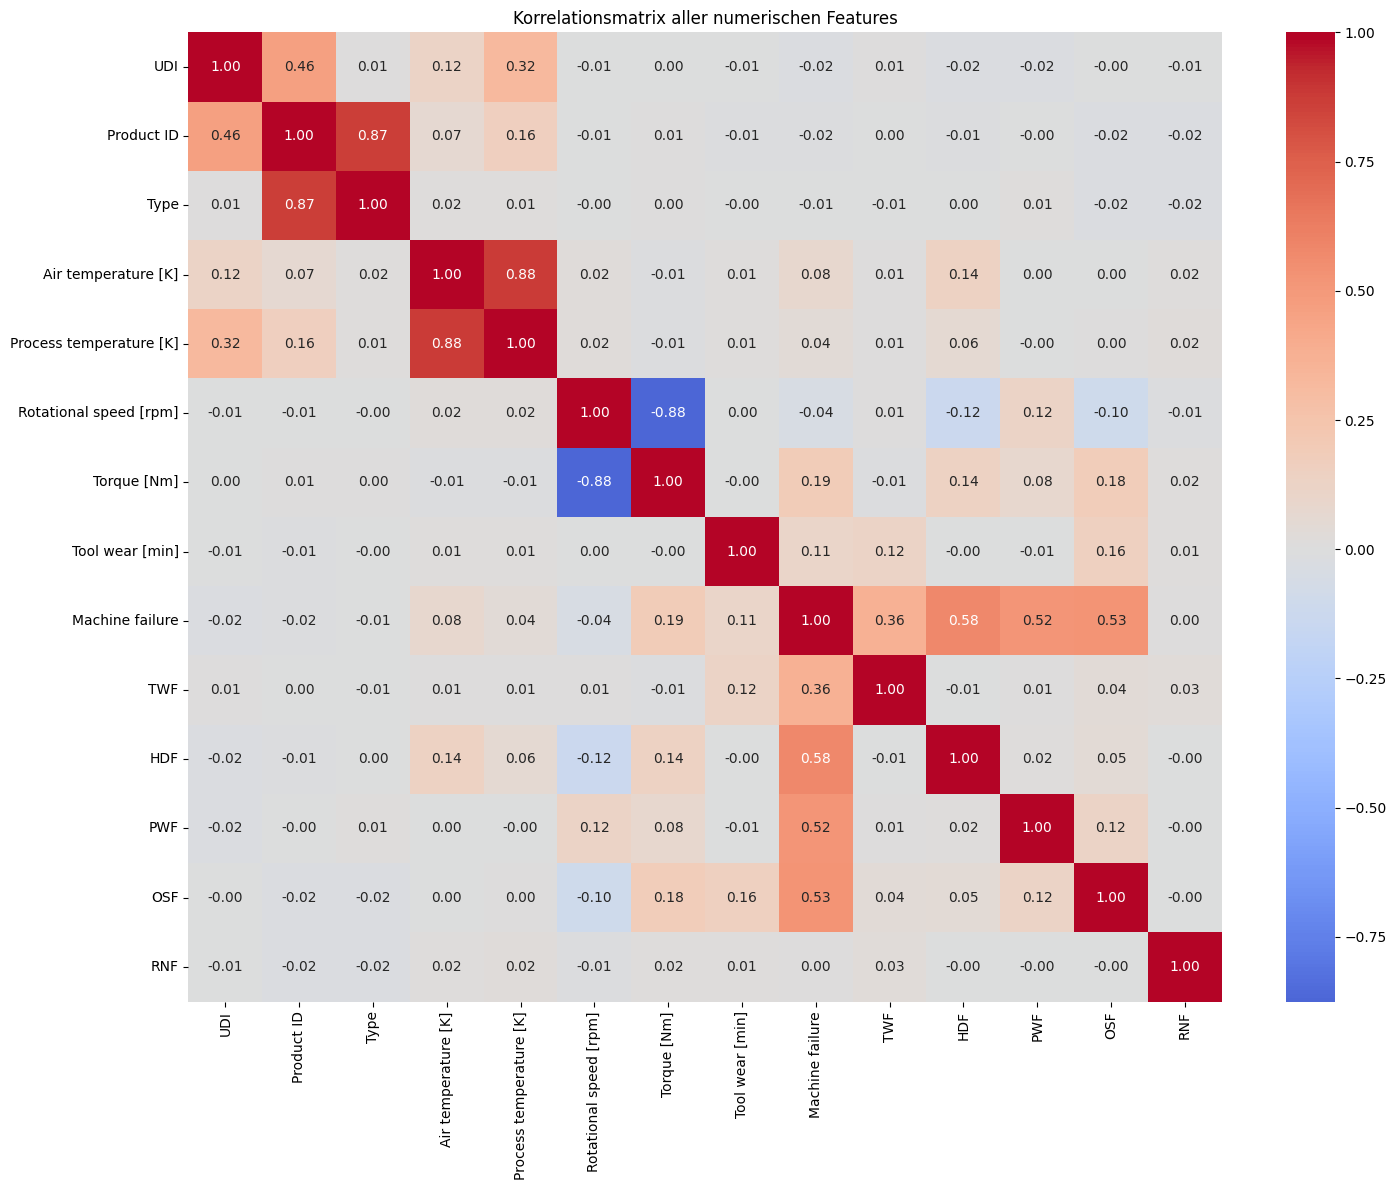


Top 10 Korrelationen mit Machine failure:
Machine failure            1.000000
HDF                        0.575800
OSF                        0.531083
PWF                        0.522812
TWF                        0.362904
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Air temperature [K]        0.082556
Rotational speed [rpm]     0.044188
Process temperature [K]    0.035946
UDI                        0.022892
Name: Machine failure, dtype: float64


In [26]:
# Korrelationsanalyse
plt.figure(figsize=(15, 12))
correlation_matrix = df_processed.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Korrelationsmatrix aller numerischen Features')
plt.tight_layout()
plt.show()

# Top Korrelationen mit Target
if target_col in correlation_matrix.columns:
    target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)
    print(f"\nTop 10 Korrelationen mit {target_col}:")
    print(target_corr.head(11))  # 11 weil Target selbst dabei ist

## 4. Daten aufteilen und skalieren

In [27]:
# Features und Target definieren
# WICHTIG: Alle Ausfallvariablen UND Identifier aus Features entfernen
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
all_failure_cols = [target_col] + [ft for ft in failure_types if ft in df_processed.columns]

# Identifier-Spalten die nicht als Features verwendet werden sollen
identifier_cols = ['UDI', 'Product ID']

# Alle zu entfernenden Spalten
cols_to_remove = all_failure_cols + identifier_cols

print(f"=== FEATURE-TARGET AUFTEILUNG ===")
print(f"Target Variable: {target_col}")
print(f"Ausfallvariablen (werden aus Features entfernt): {all_failure_cols}")
print(f"Identifier-Spalten (werden aus Features entfernt): {identifier_cols}")
print(f"Alle zu entfernenden Spalten: {cols_to_remove}")

if target_col:
    # Features: Alle Spalten AUSSER Ausfallvariablen und Identifiern
    X = df_processed.drop(columns=[col for col in cols_to_remove if col in df_processed.columns])
    y = df_processed[target_col]
    
    print(f"\nFeature Matrix Shape: {X.shape}")
    print(f"Target Vector Shape: {y.shape}")
    print(f"Features ({len(X.columns)}): {list(X.columns)}")
    
    # Prüfung: Sind alle problematischen Spalten entfernt?
    remaining_problem_cols = [col for col in cols_to_remove if col in X.columns]
    if remaining_problem_cols:
        print(f"⚠️  WARNUNG: Folgende problematische Spalten noch in Features: {remaining_problem_cols}")
    else:
        print("✅ Alle Ausfallvariablen und Identifier erfolgreich aus Features entfernt")
        print("✅ Data Leakage und Overfitting durch IDs vermieden")
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTraining Set: {X_train.shape}")
    print(f"Test Set: {X_test.shape}")
    print(f"Training Target Distribution: {y_train.value_counts().to_dict()}")
    print(f"Test Target Distribution: {y_test.value_counts().to_dict()}")
    
    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n=== SKALIERUNG ===")
    print(f"Skalierung abgeschlossen!")
    print(f"Feature Means (nach Skalierung): {X_train_scaled.mean(axis=0)[:5]}...")  # Erste 5
    print(f"Feature Stds (nach Skalierung): {X_train_scaled.std(axis=0)[:5]}...")   # Erste 5
    
    print(f"\n=== FINALE FEATURES FÜR MODELLIERUNG ===")
    print(f"Anzahl Features: {len(X.columns)}")
    print(f"Feature Liste: {list(X.columns)}")
    print("Diese Features werden für alle ML-Modelle verwendet")
    
else:
    print("❌ Fehler: Target-Variable nicht definiert!")

=== FEATURE-TARGET AUFTEILUNG ===
Target Variable: Machine failure
Alle Ausfallvariablen (werden aus Features entfernt): ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

Feature Matrix Shape: (10000, 8)
Target Vector Shape: (10000,)
Features (8): ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
✅ Alle Ausfallvariablen erfolgreich aus Features entfernt (Data Leakage vermieden)

Training Set: (8000, 8)
Test Set: (2000, 8)
Training Target Distribution: {0: 7729, 1: 271}
Test Target Distribution: {0: 1932, 1: 68}

=== SKALIERUNG ===
Skalierung abgeschlossen!
Feature Means (nach Skalierung): [-5.68434189e-17  5.06261699e-17 -8.88178420e-17  1.75859327e-15
  1.05346842e-14]...
Feature Stds (nach Skalierung): [1. 1. 1. 1. 1.]...

=== INFO ===
Verfügbare spezifische Ausfalltypen im Dataset: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Diese werden NICHT als Features verwendet (Data Leakage Prevention)


## 5. Model Training und Vergleich

In [29]:
# Dictionary für Modelle und Ergebnisse
models = {}
results = {}

# 1. Logistic Regression (mit skalierten Daten)
print("Training Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr

# 2. Random Forest (mit originalen Daten)
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
models['Random Forest'] = rf

# 3. Decision Tree
print("Training Decision Tree...")
dt = DecisionTreeClassifier(random_state=42, max_depth=10)
dt.fit(X_train, y_train)
models['Decision Tree'] = dt

# 4. SVM (mit skalierten Daten)
print("Training SVM...")
svm = SVC(random_state=42, probability=True, kernel='rbf')
svm.fit(X_train_scaled, y_train)
models['SVM'] = svm

"""
# 5. XGBoost (falls verfügbar)
if XGBOOST_AVAILABLE:
    print("Training XGBoost...")
    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    models['XGBoost'] = xgb_model
    """

print(f"\nTraining abgeschlossen! {len(models)} Modelle trainiert.")

Training Logistic Regression...
Training Random Forest...
Training Decision Tree...
Training SVM...

Training abgeschlossen! 4 Modelle trainiert.

Training abgeschlossen! 4 Modelle trainiert.


In [30]:
# Modell-Evaluation
evaluation_results = []

for name, model in models.items():
    print(f"\n=== Evaluierung: {name} ===")
    
    # Bestimmen welche Daten zu verwenden sind
    if name in ['Logistic Regression', 'SVM']:
        X_train_eval = X_train_scaled
        X_test_eval = X_test_scaled
    else:
        X_train_eval = X_train
        X_test_eval = X_test
    
    # Predictions
    y_pred = model.predict(X_test_eval)
    y_pred_proba = model.predict_proba(X_test_eval)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metriken berechnen
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # AUC-ROC (falls Wahrscheinlichkeiten verfügbar)
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Cross-Validation Score
    cv_scores = cross_val_score(model, X_train_eval, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Ergebnisse speichern
    result = {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'CV Mean': cv_mean,
        'CV Std': cv_std
    }
    evaluation_results.append(result)
    
    # Ausgabe
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if auc_roc:
        print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"CV Score: {cv_mean:.4f} (±{cv_std:.4f})")

# Ergebnisse als DataFrame
results_df = pd.DataFrame(evaluation_results)
print("\n=== Modell-Vergleich ===")
print(results_df.round(4))


=== Evaluierung: Logistic Regression ===
Accuracy: 0.9680
Precision: 0.9595
Recall: 0.9680
F1-Score: 0.9570
AUC-ROC: 0.8999
CV Score: 0.9705 (±0.0018)

=== Evaluierung: Random Forest ===
Accuracy: 0.9860
Precision: 0.9854
Recall: 0.9860
F1-Score: 0.9847
AUC-ROC: 0.9678
CV Score: 0.9836 (±0.0009)

=== Evaluierung: Decision Tree ===
Accuracy: 0.9810
Precision: 0.9797
Recall: 0.9810
F1-Score: 0.9801
AUC-ROC: 0.7799
CV Score: 0.9806 (±0.0016)

=== Evaluierung: SVM ===
Accuracy: 0.9860
Precision: 0.9854
Recall: 0.9860
F1-Score: 0.9847
AUC-ROC: 0.9678
CV Score: 0.9836 (±0.0009)

=== Evaluierung: Decision Tree ===
Accuracy: 0.9810
Precision: 0.9797
Recall: 0.9810
F1-Score: 0.9801
AUC-ROC: 0.7799
CV Score: 0.9806 (±0.0016)

=== Evaluierung: SVM ===
Accuracy: 0.9700
Precision: 0.9662
Recall: 0.9700
F1-Score: 0.9597
AUC-ROC: 0.9488
CV Score: 0.9729 (±0.0012)

=== Modell-Vergleich ===
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0  Logistic Regression     0.968     0

## 6. Visualisierung der Ergebnisse

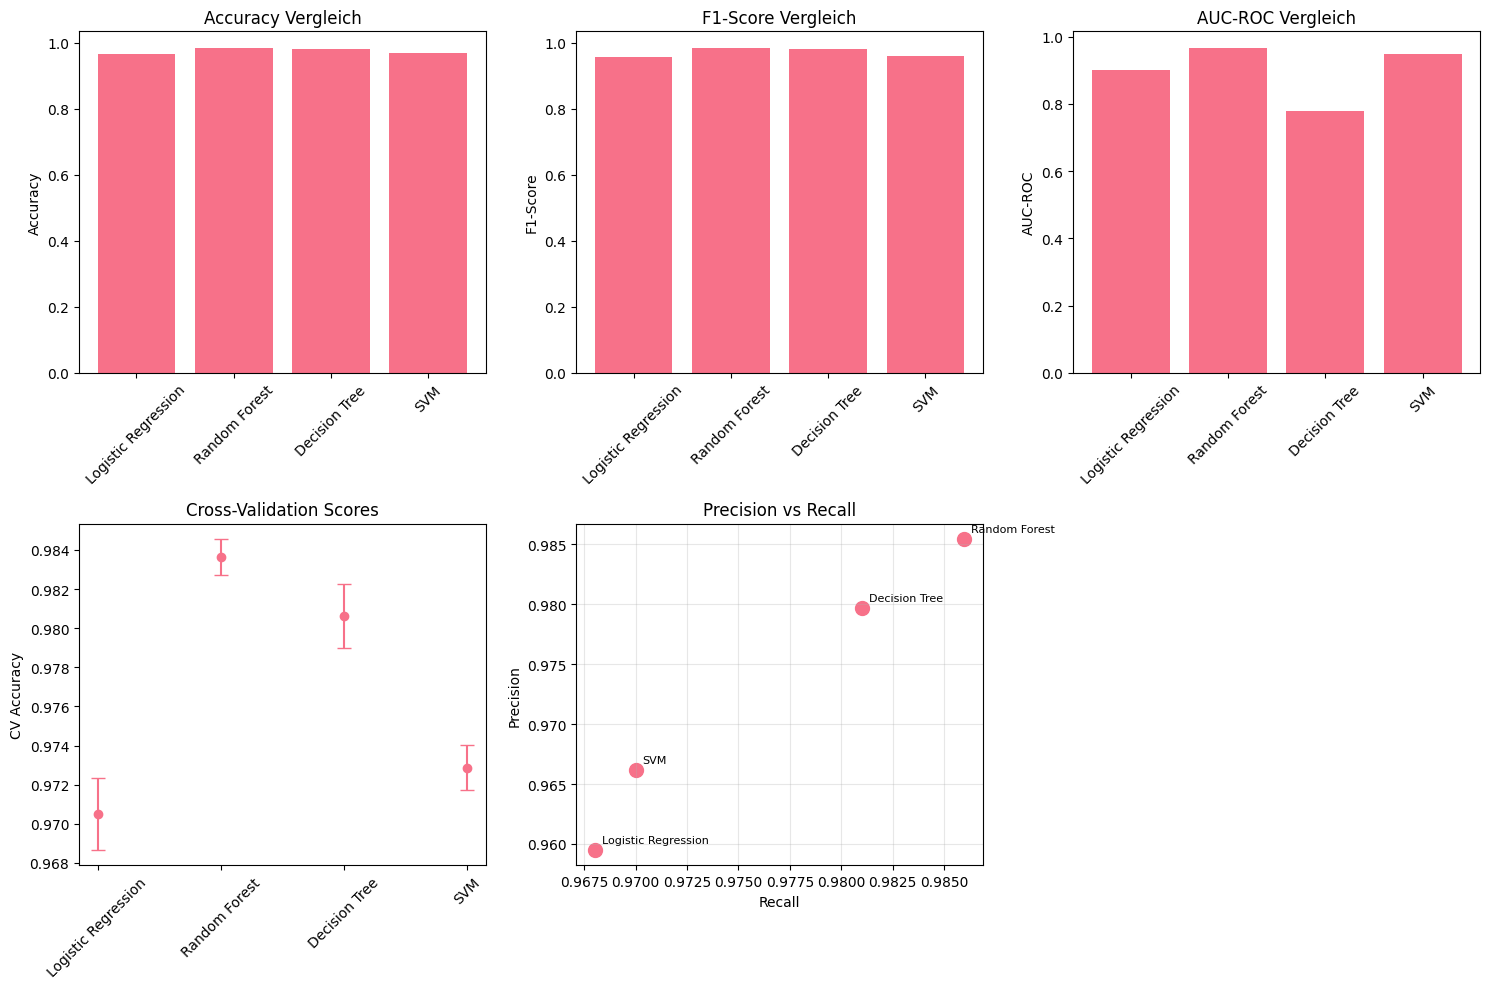

In [31]:
# Modell-Performance Vergleich
plt.figure(figsize=(15, 10))

# Subplot 1: Accuracy Vergleich
plt.subplot(2, 3, 1)
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.title('Accuracy Vergleich')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

# Subplot 2: F1-Score Vergleich
plt.subplot(2, 3, 2)
plt.bar(results_df['Model'], results_df['F1-Score'])
plt.title('F1-Score Vergleich')
plt.xticks(rotation=45)
plt.ylabel('F1-Score')

# Subplot 3: AUC-ROC Vergleich (nur für Modelle mit Wahrscheinlichkeiten)
auc_data = results_df.dropna(subset=['AUC-ROC'])
if not auc_data.empty:
    plt.subplot(2, 3, 3)
    plt.bar(auc_data['Model'], auc_data['AUC-ROC'])
    plt.title('AUC-ROC Vergleich')
    plt.xticks(rotation=45)
    plt.ylabel('AUC-ROC')

# Subplot 4: Cross-Validation Scores
plt.subplot(2, 3, 4)
plt.errorbar(range(len(results_df)), results_df['CV Mean'], 
            yerr=results_df['CV Std'], fmt='o', capsize=5)
plt.xticks(range(len(results_df)), results_df['Model'], rotation=45)
plt.title('Cross-Validation Scores')
plt.ylabel('CV Accuracy')

# Subplot 5: Precision vs Recall
plt.subplot(2, 3, 5)
plt.scatter(results_df['Recall'], results_df['Precision'], s=100)
for i, model in enumerate(results_df['Model']):
    plt.annotate(model, (results_df['Recall'].iloc[i], results_df['Precision'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Bestes Modell basierend auf F1-Score: Random Forest


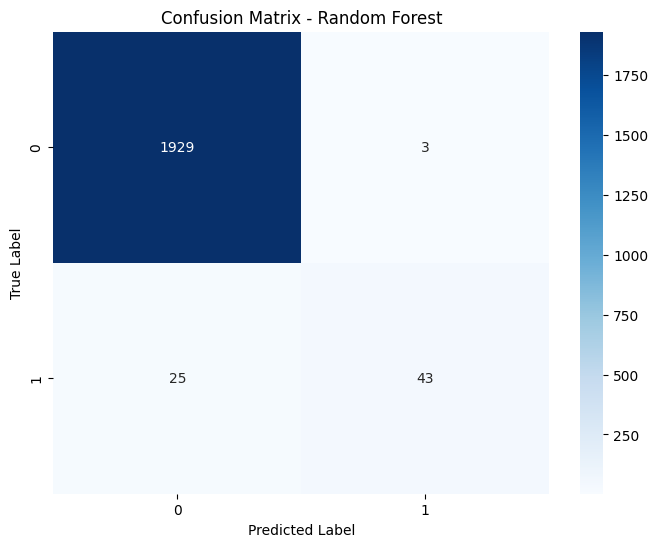


Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.93      0.63      0.75        68

    accuracy                           0.99      2000
   macro avg       0.96      0.82      0.87      2000
weighted avg       0.99      0.99      0.98      2000



In [32]:
# Confusion Matrix für das beste Modell
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df['Model'].iloc[best_model_idx]
best_model = models[best_model_name]

print(f"Bestes Modell basierend auf F1-Score: {best_model_name}")

# Predictions für das beste Modell
if best_model_name in ['Logistic Regression', 'SVM']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, y_pred_best))

## 7. Feature Importance (für Tree-based Models)

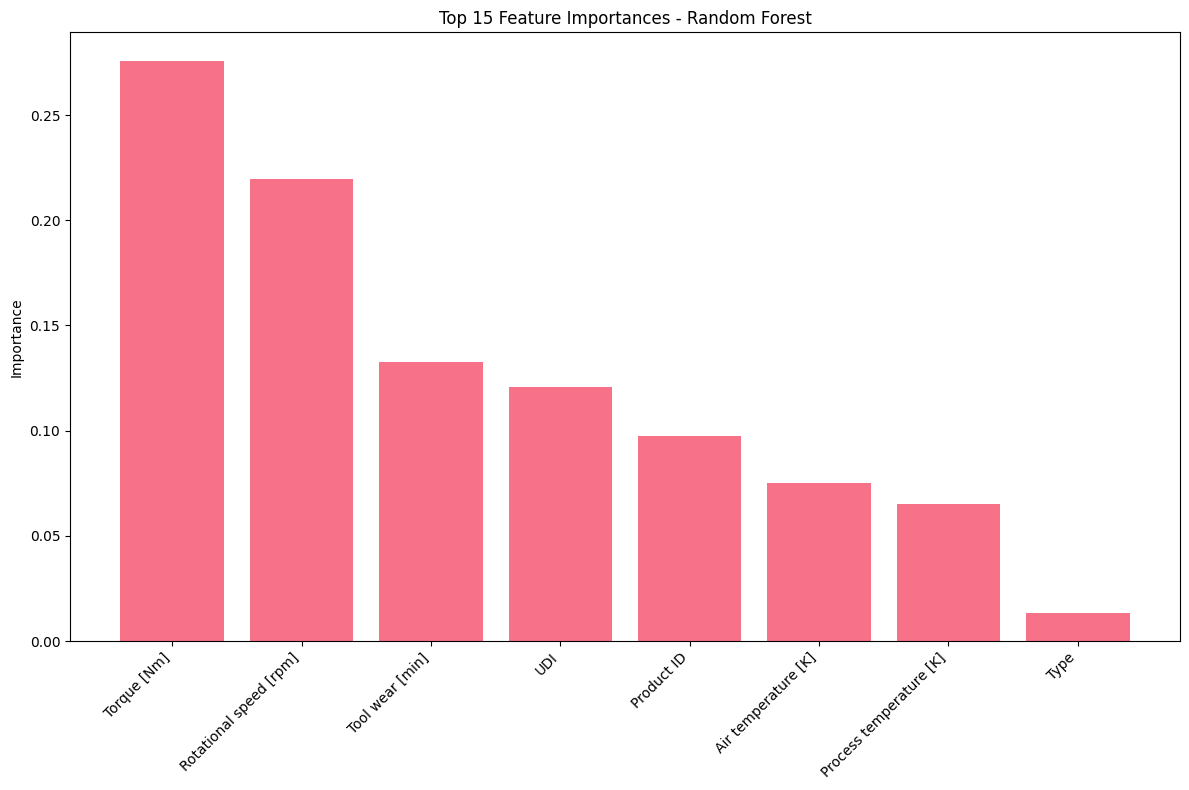


Top 10 wichtigste Features - Random Forest:
                   Feature  Importance
6              Torque [Nm]      0.2756
5   Rotational speed [rpm]      0.2195
7          Tool wear [min]      0.1329
0                      UDI      0.1207
1               Product ID      0.0976
3      Air temperature [K]      0.0752
4  Process temperature [K]      0.0651
2                     Type      0.0135


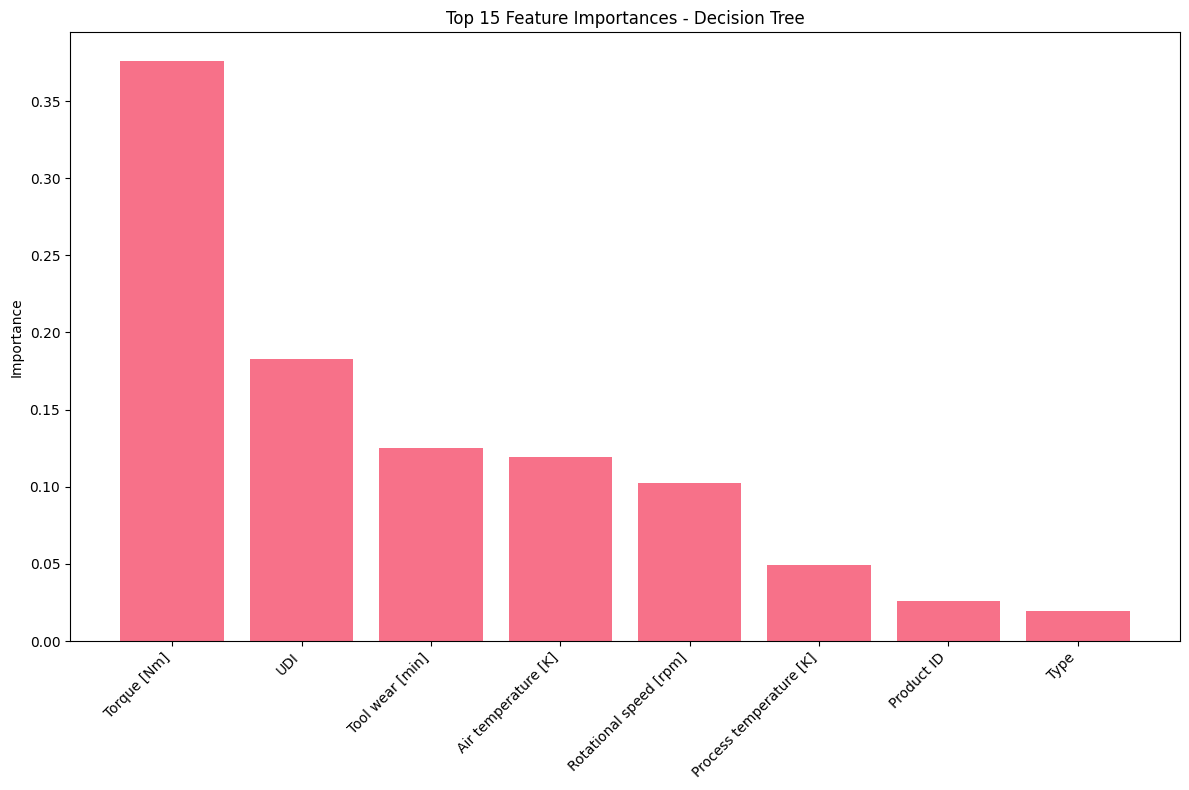


Top 10 wichtigste Features - Decision Tree:
                   Feature  Importance
6              Torque [Nm]      0.3757
0                      UDI      0.1827
7          Tool wear [min]      0.1252
3      Air temperature [K]      0.1195
5   Rotational speed [rpm]      0.1023
4  Process temperature [K]      0.0492
1               Product ID      0.0260
2                     Type      0.0194


In [33]:
# Feature Importance für Modelle, die es unterstützen
feature_importance_models = ['Random Forest', 'Decision Tree', 'XGBoost']

for model_name in feature_importance_models:
    if model_name in models:
        model = models[model_name]
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_names = X.columns
            
            # Top 15 wichtigste Features
            indices = np.argsort(importances)[::-1][:15]
            
            plt.figure(figsize=(12, 8))
            plt.title(f'Top 15 Feature Importances - {model_name}')
            plt.bar(range(len(indices)), importances[indices])
            plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
            plt.ylabel('Importance')
            plt.tight_layout()
            plt.show()
            
            # Feature Importance als DataFrame
            feature_imp_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print(f"\nTop 10 wichtigste Features - {model_name}:")
            print(feature_imp_df.head(10).round(4))

## 8. ROC Curves (für Modelle mit Wahrscheinlichkeiten)

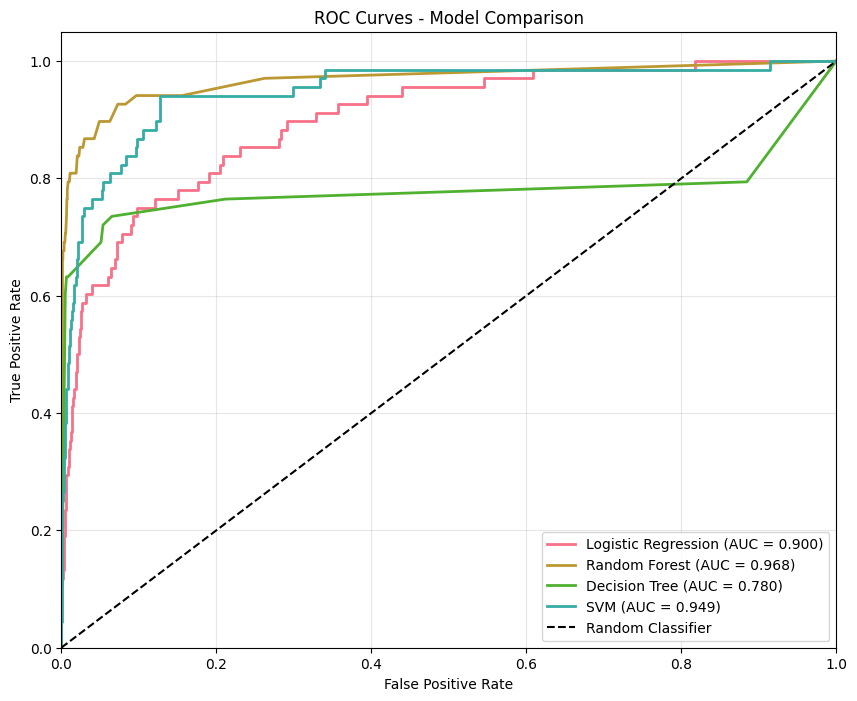

In [34]:
# ROC Curves für alle Modelle mit predict_proba
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        # Bestimmen welche Daten zu verwenden sind
        if name in ['Logistic Regression', 'SVM']:
            X_test_eval = X_test_scaled
        else:
            X_test_eval = X_test
        
        y_pred_proba = model.predict_proba(X_test_eval)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

# Diagonale (Random Classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## 9. Zusammenfassung und nächste Schritte

In [35]:
# Finale Zusammenfassung
print("=== EXPERIMENT ZUSAMMENFASSUNG ===")
print(f"Dataset: {df.shape[0]} Samples, {df.shape[1]} Original Features")
print(f"Nach Feature Engineering: {df_processed.shape[1]} Features")
print(f"Target Variable: {target_col}")
print(f"Target Distribution: {dict(y.value_counts())}")

print(f"\n=== MODELL PERFORMANCE ===")
results_sorted = results_df.sort_values('F1-Score', ascending=False)
print(results_sorted[['Model', 'Accuracy', 'F1-Score', 'AUC-ROC']].round(4))

print(f"\n=== BESTE MODELLE ===")
print(f"Beste Accuracy: {results_sorted.iloc[0]['Model']} ({results_sorted.iloc[0]['Accuracy']:.4f})")
print(f"Beste F1-Score: {results_sorted.iloc[0]['Model']} ({results_sorted.iloc[0]['F1-Score']:.4f})")

if not auc_data.empty:
    best_auc_idx = auc_data['AUC-ROC'].idxmax()
    print(f"Beste AUC-ROC: {auc_data.iloc[best_auc_idx]['Model']} ({auc_data.iloc[best_auc_idx]['AUC-ROC']:.4f})")

print(f"\n=== NÄCHSTE SCHRITTE ===")
print("1. Hyperparameter-Tuning für beste Modelle")
print("2. Ensemble-Methoden ausprobieren")
print("3. Feature Selection verfeinern")
print("4. Cross-Validation mit mehr Folds")
print("5. Mehr Advanced Feature Engineering")
print("6. Model Interpretability (SHAP, LIME)")
print("7. Production Pipeline entwickeln")

=== EXPERIMENT ZUSAMMENFASSUNG ===
Dataset: 10000 Samples, 14 Original Features
Nach Feature Engineering: 14 Features
Target Variable: Machine failure
Target Distribution: {0: 9661, 1: 339}

=== MODELL PERFORMANCE ===
                 Model  Accuracy  F1-Score  AUC-ROC
1        Random Forest     0.986    0.9847   0.9678
2        Decision Tree     0.981    0.9801   0.7799
3                  SVM     0.970    0.9597   0.9488
0  Logistic Regression     0.968    0.9570   0.8999

=== BESTE MODELLE ===
Beste Accuracy: Random Forest (0.9860)
Beste F1-Score: Random Forest (0.9847)
Beste AUC-ROC: Random Forest (0.9678)

=== NÄCHSTE SCHRITTE ===
1. Hyperparameter-Tuning für beste Modelle
2. Ensemble-Methoden ausprobieren
3. Feature Selection verfeinern
4. Cross-Validation mit mehr Folds
5. Mehr Advanced Feature Engineering
6. Model Interpretability (SHAP, LIME)
7. Production Pipeline entwickeln


In [36]:
# Optional: Modell speichern
import joblib
import os

# Modell-Verzeichnis erstellen falls nicht vorhanden
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Bestes Modell speichern
best_model_path = f'{model_dir}/best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
scaler_path = f'{model_dir}/scaler.pkl'

joblib.dump(best_model, best_model_path)
joblib.dump(scaler, scaler_path)

print(f"Bestes Modell gespeichert: {best_model_path}")
print(f"Scaler gespeichert: {scaler_path}")

# Auch die Ergebnisse speichern
results_path = f'{model_dir}/experiment_results.csv'
results_df.to_csv(results_path, index=False)
print(f"Experiment Ergebnisse gespeichert: {results_path}")

Bestes Modell gespeichert: ../models/best_model_random_forest.pkl
Scaler gespeichert: ../models/scaler.pkl
Experiment Ergebnisse gespeichert: ../models/experiment_results.csv
